<a href="https://colab.research.google.com/github/AKBER-HUSSAIN/ML_Assignment/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this exercise, you will experiment with regression, regularization, and cross-validation. Choose
appropriate Dataset.


(a) Load the data into memory. Make an appropriate X matrix and y vector.

(b) Split the data at random into one set (Xtrain, ytrain) containing 80% of the instances, which will
be used for training + validation, and a testing set Xtest, ytest (containing remaining instances).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/dataset/diabetes.csv")

# Columns where 0 means missing
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with NaN
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Fill NaN with median values
imputer = SimpleImputer(strategy="median")
df[cols_with_zeros] = imputer.fit_transform(df[cols_with_zeros])

# Split into features & target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(c) Give the objective of logistic regression with L2 regularization.

Ridge regression, also known as L2 regularization, is a technique used in linear regression to prevent overfitting by adding a penalty term to the loss function. This penalty is proportional to the square of the magnitude of the coefficients (weights).

Ridge Regression is a version of linear regression that includes a penalty to prevent the model from overfitting, especially when there are many predictors or not enough data.

The standard loss function (mean squared error) is modified to include a regularization term:


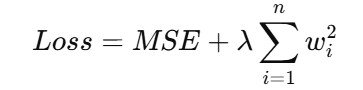


Here, 𝜆 λ is the regularization parameter that controls the strength of the penalty, and wi are the coefficients.

Encouraging the model's coefficients to be small but not exactly zero.
It helps to prevent any one feature from having an overly dominant effect on the predictions.
The larger the ' λ ' value, the stronger the regularization, and the smaller the coefficients will become

(d) Run logistic regression on the data using L2 regularization, varying the regularization parameter
λ ∈ {0, 0.1, 1, 10, 100, 1000}. Plot on one graph the average cross-entropy for the training data
and the testing data (averaged over all instances), as a function of λ (you should use a log scale
for λ). Plot on another graph the L2 norm of the weight vector you obtain. Plot on the third
graph the actual values of the weights obtained (one curve per weight). Finally, plot on a
graph the accuracy on the training and test set. Explain briefly what you see.

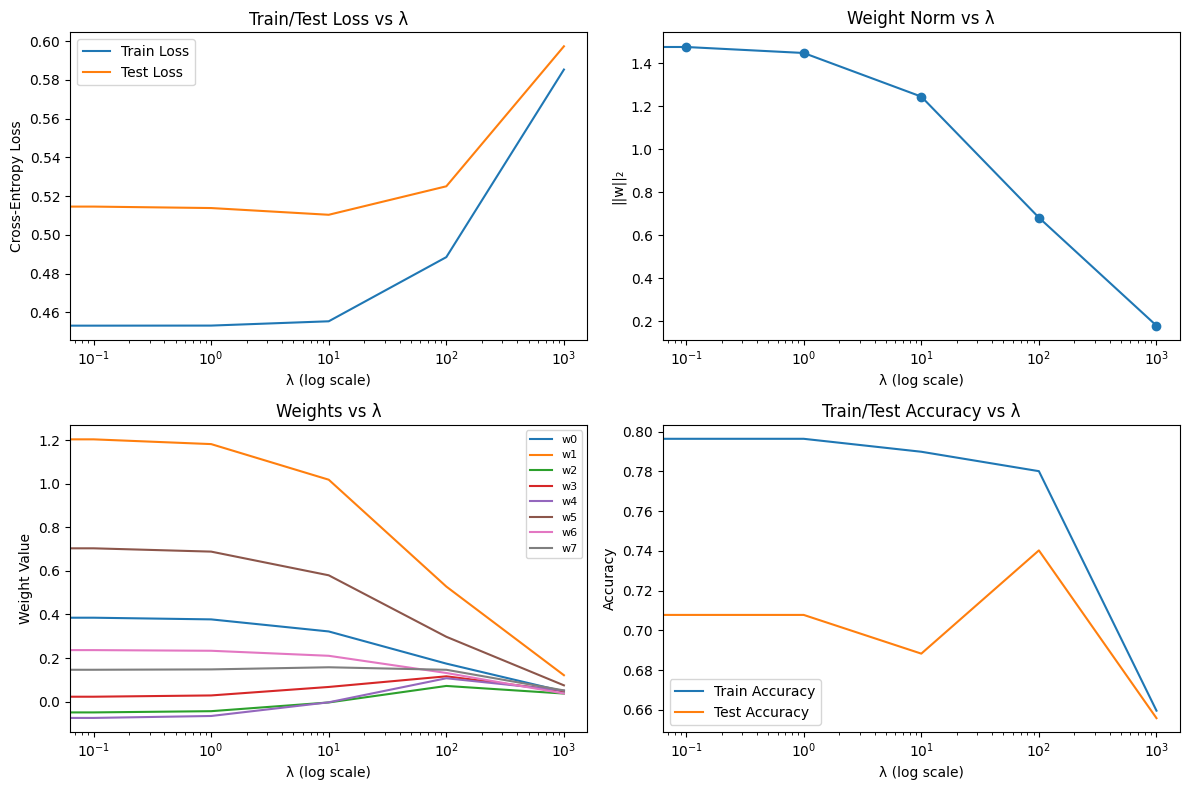

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# λ values (regularization strength)
lambdas = [0, 0.1, 1, 10, 100, 1000]

train_losses = []
test_losses = []
train_acc = []
test_acc = []
weight_norms = []
weights_list = []

for lam in lambdas:
    # In sklearn, C = 1 / λ  (set C very large for λ=0)
    C = 1e12 if lam == 0 else 1 / lam

    model = LogisticRegression(
        penalty="l2", C=C, solver="lbfgs", max_iter=500
    )
    model.fit(X_train, y_train)

    # Predictions
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Cross-entropy loss
    train_losses.append(log_loss(y_train, y_train_prob))
    test_losses.append(log_loss(y_test, y_test_prob))

    # Accuracy
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))
    test_acc.append(accuracy_score(y_test, model.predict(X_test)))

    # Store weight info
    weight_vector = model.coef_[0]
    weight_norms.append(np.linalg.norm(weight_vector))
    weights_list.append(weight_vector)

# ---- PLOTS ----
plt.figure(figsize=(12, 8))

# Plot 1: Training vs Testing Loss
plt.subplot(2, 2, 1)
plt.semilogx(lambdas, train_losses, label="Train Loss")
plt.semilogx(lambdas, test_losses, label="Test Loss")
plt.xlabel("λ (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Train/Test Loss vs λ")
plt.legend()

# Plot 2: Weight Norm
plt.subplot(2, 2, 2)
plt.semilogx(lambdas, weight_norms, marker='o')
plt.xlabel("λ (log scale)")
plt.ylabel("||w||₂")
plt.title("Weight Norm vs λ")

# Plot 3: Weight values
plt.subplot(2, 2, 3)
weights_array = np.array(weights_list)
for i in range(weights_array.shape[1]):
    plt.semilogx(lambdas, weights_array[:, i], label=f"w{i}")
plt.xlabel("λ (log scale)")
plt.ylabel("Weight Value")
plt.title("Weights vs λ")
plt.legend(fontsize=8)

# Plot 4: Accuracy
plt.subplot(2, 2, 4)
plt.semilogx(lambdas, train_acc, label="Train Accuracy")
plt.semilogx(lambdas, test_acc, label="Test Accuracy")
plt.xlabel("λ (log scale)")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy vs λ")
plt.legend()

plt.tight_layout()
plt.show()


As λ increases, the model’s weights get smaller, which makes the model simpler. This reduces overfitting but can also make the model underfit if λ is too large. We see that for very high λ, the loss increases and accuracy drops. In short — small λ gives better accuracy, but too much regularization hurts performance.

(e)Re-format the data in the following way: take each of the input variables, and feed it through
a set of Gaussian basis functions, defined as follows. For each variable (except the bias term),
use 5 univariate basis functions with means evenly spaced between -10 and 10 and variance σ.
You will experiment with σ values of 0.1, 0.5, 1, 5 and 10.

In [ ]:
def gaussian_basis(X, num_bases=5, sigma=1.0, feature_range=(-10, 10)):
    n_samples, n_features = X.shape
    means = np.linspace(feature_range[0], feature_range[1], num_bases)

    X_transformed = []

    for i in range(n_features):
        for mu in means:
            phi = np.exp(-(X[:, i] - mu) ** 2 / (2 * sigma ** 2))
            X_transformed.append(phi)

    return np.column_stack(X_transformed)

sigma_values = [0.1, 0.5, 1, 5, 10]


X_train_gaussian = {}
X_test_gaussian = {}

print("Original X_train shape:", X_train.shape)
print("-" * 60)

for sigma in sigma_values:
    X_train_gauss = gaussian_basis(X_train.values, num_bases=5, sigma=sigma)
    X_test_gauss  = gaussian_basis(X_test.values, num_bases=5, sigma=sigma)

    X_train_gaussian[sigma] = X_train_gauss
    X_test_gaussian[sigma]  = X_test_gauss

    print(f"Sigma = {sigma}")
    print("Transformed X_train shape:", X_train_gauss.shape)
    print("Transformed X_test  shape:", X_test_gauss.shape)
    print("-" * 60)


Original X_train shape: (614, 8)
------------------------------------------------------------


AttributeError: 'numpy.ndarray' object has no attribute 'values'